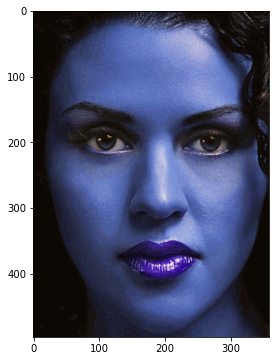

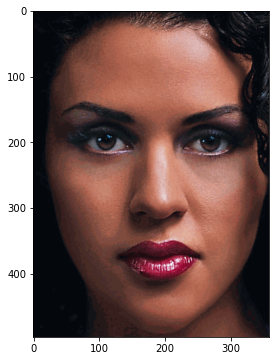

In [1]:
import cv2 as cv
import numpy as np    
import matplotlib.pyplot as plt
from PIL import Image

def rc(channel):
    row = channel.shape[0]
    col = channel.shape[1]
    return row, col
    
def negative_channel(channel):
    channel = 255 -channel
    return channel

def fix(channel):
    for x in range(channel.shape[0]):
        for y in range(channel.shape[1]):
            if channel[x][y] < 0:
                channel[x][y] = 0
            if channel[x][y] > 255:
                channel[x][y] = 255
    return channel

def new_filter(channel, model, *size):
    row, col = rc(channel)
    
    if model == 'mean':    
        filtro = np.ones((size[0], size[0]))
        filtro /= filtro.sum()
    elif model == 'sobel-horizontal':
        filtro = np.array([[-1,-2,-1],[0,0,0],[1,2,1]]) 
    elif model == 'sobel-vertical':
        filtro = np.array([[-1,0,1],[-2,0,2],[-1,0,1]]) 
        
    if model == 'median':
        row_filter, col_filter = size[0], size[0]
    else:
        row_filter, col_filter = rc(filtro)
        
    final_row = row+row_filter -1
    final_col = col+col_filter -1    
    matrix = np.zeros((final_row, final_col))
    
    for x in range(row):
        for y in range(col):
            matrix[x+np.uint8((row_filter-1)/2), y+np.uint8((col_filter-1)/2)] = channel[x][y]
    for x in range(row):
        for y in range(col):
            k = matrix[x:x+row_filter, y:y+col_filter]            
            if model == 'median':
                l = np.median(k)
            elif model == 'mean':
                l = np.sum(k*filtro)
            elif model == 'sobel-horizontal' or 'sobel-vertical':
                l = np.absolute(np.sum(k*filtro))                
            channel[x][y] = l                
    return channel

def histogram_expansion_channel(channel):
    L = 255
    row, col = rc(channel)
    r_min = np.min(channel)
    r_max = np.max(channel)    
    histogram_expansion = np.zeros((row, col), dtype=np.uint8)
    for x in range(row):
        for y in range(col):            
            r = channel[x][y]
            histogram_expansion[x][y] = (r-r_min)*(L-1)//(r_max-r_min)
    return histogram_expansion

def rgb_to_yiq(img):
    r, g, b = cv.split(img)
    y = (0.299)*r +(0.587)*g +(0.114)*b
    i = (0.596)*r +(-0.274)*g +(-0.322)*b
    q = (0.211)*r +(-0.523)*g +(0.312)*b 
    img_yiq = cv.merge([y,i,q])    
    return img_yiq

def yiq_to_rgb(img):
    y, i, q = cv.split(img)
    r = y +(0.956*i)  +(0.621*q)
    g = y +(-0.272*i) +(-0.647*q)
    b = y +(-1.106*i) +(1.703*q)    
    r = fix(r)
    g = fix(g)
    b = fix(b)
    img_rgb = cv.merge([r,g,b])
    return img_rgb   

def negative_rgb(img):
    r, g, b = cv.split(img)
    negative_r = negative_channel(r)
    negative_g = negative_channel(g)
    negative_b = negative_channel(b)
    negative_img = cv.merge([negative_r, negative_g, negative_b])
    return negative_img

def negative_y(img):
    y,i,q = cv.split(img)
    negative_y = negative_channel(y)
    negative_img = cv.merge([negative_y,i,q])
    return negative_img

def offset(img, offset):
    r, g, b = cv.split(img)
    r = r+offset
    g = g+offset
    b = b+offset    
    fix(r)
    fix(g)
    fix(b)
    img2 = cv.merge([r,g,b])
    printImg(img2)    
    
def pivot_channel(channel, row_pivot, col_pivot):
    row, col = rc(channel)
    pivot_channel = np.zeros((row, col), dtype=np.uint8)
    for x in range(row):
        for y in range(col):
            if x+row_pivot <= row-1 and y+col_pivot <= col-1:
                pivot_channel[x+row_pivot][y+col_pivot] = channel[x][y]               
    return pivot_channel


def pivot(img, row, col):
    x, y = rc(img)
    r, g, b, = cv.split(img)
    r = pivot_channel(r, row, col)    
    g = pivot_channel(g, row, col)    
    b = pivot_channel(b, row, col)
    img2 = cv.merge([r,g,b])
    printImg(img2)

def printImg(img):    
    plt.rcParams['figure.figsize'] = (6,6) 
    plt.imshow(img)
    plt.show()

def q1(img):
    x = yiq_to_rgb(rgb_to_yiq(img))/255
    printImg(x)
    return 

def q2p1(img):
    x = negative_rgb(img)/255
    printImg(x)
    return 

def q2p2(img):
    x = yiq_to_rgb(negative_y(rgb_to_yiq(img)))/255
    printImg(x)
    return 

def q3p1(img, tamanho_filtro):
    r,g,b = cv.split(img)
    channel1 = new_filter(r, 'mean', tamanho_filtro)
    channel2 = new_filter(g, 'mean', tamanho_filtro)
    channel3 = new_filter(b, 'mean', tamanho_filtro)    
    filtro = cv.merge([channel1, channel2, channel3])
    printImg(filtro/255)
    return

def q3p2(img):    
    r,g,b = cv.split(img)     
    channel1 = new_filter(r, 'sobel-horizontal')
    channel2 = new_filter(g, 'sobel-horizontal')
    channel3 = new_filter(b, 'sobel-horizontal')
    channel1 = histogram_expansion_channel(channel1)
    channel2 = histogram_expansion_channel(channel2)
    channel3 = histogram_expansion_channel(channel3)  
    filtro = cv.merge([channel1, channel2, channel3])    
    x = filtro/255
    printImg(x)
    return 
    
def q3p3(img):    
    r,g,b = cv.split(img)
    channel1 = new_filter(r, 'sobel-vertical')
    channel2 = new_filter(g, 'sobel-vertical')
    channel3 = new_filter(b, 'sobel-vertical')
    channel1 = histogram_expansion_channel(channel1)
    channel2 = histogram_expansion_channel(channel2)
    channel3 = histogram_expansion_channel(channel3)
    filtro = cv.merge([channel1, channel2, channel3])    
    x = filtro/255
    printImg(x)  
    return 


def q4(img, tamanho_filtro):
    img2 = rgb_to_yiq(img)
    y,i,q = cv.split(img2)
    channel1 = new_filter(y, 'median', tamanho_filtro)
    img2 = cv.merge([channel1, i, q])
    filtro = yiq_to_rgb(img2)
    x = filtro/255
    printImg(x)
    return         

img1 = cv.imread('Woman.png')
printImg(img1)
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
printImg(img1)
img2 = cv.imread('Woman_eye.png')

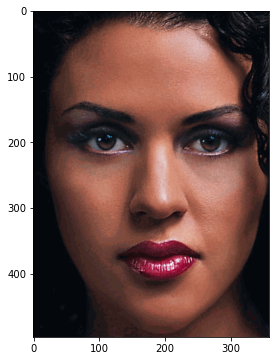

In [2]:
q1(img1)

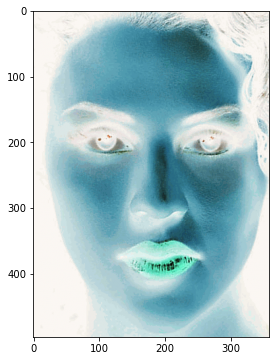

In [3]:
q2p1(img1)

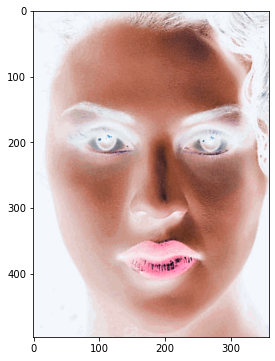

In [4]:
q2p2(img1)

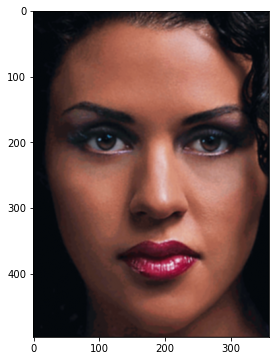

In [5]:
q3p1(img1,3)

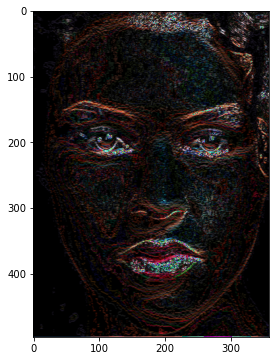

In [6]:
q3p2(img1)

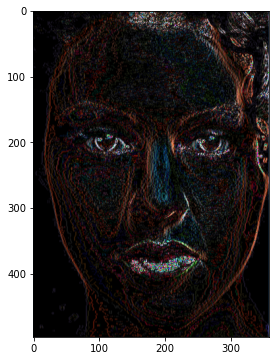

In [7]:
q3p3(img1)

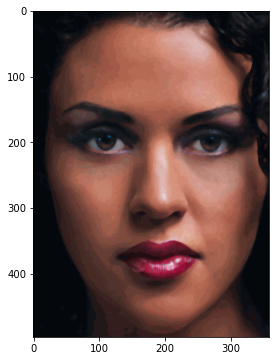

In [8]:
q4(img1,5)

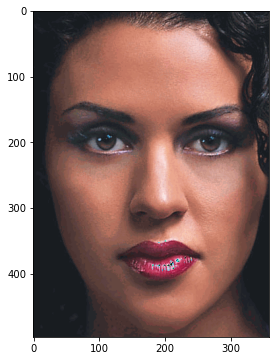

In [9]:
offset(img1, 20)    

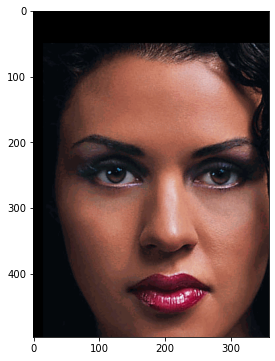

In [10]:
pivot(img1, 50,15)

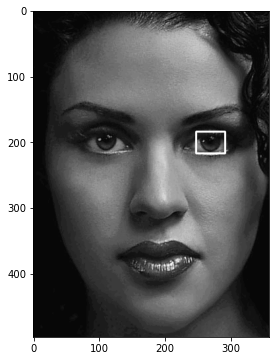

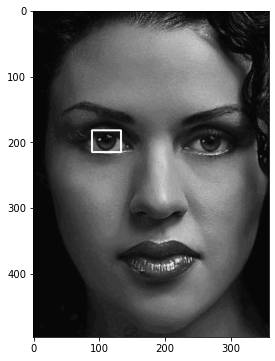

In [11]:
import cv2 as cv

img = cv.imread('Woman.png',0)
img2 = img.copy()
img3 = img.copy()
find = cv.imread('Woman_eye.png',0)
w, h = find.shape[::-1]
    
result = cv.matchTemplate(img2, find, cv.TM_CCOEFF_NORMED)

min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)

canto_superior_esquerdo = max_loc

canto_inferior_direito = (canto_superior_esquerdo[0] + w, canto_superior_esquerdo[1] + h)

cv.rectangle(img2, canto_superior_esquerdo, canto_inferior_direito, 255, 2)

a, b = max_loc
c, d = canto_inferior_direito
for i in range(b, d):
    for j in range(a, c):
        img[i,j] = 0    
        
printImg(cv.cvtColor(img2, cv.COLOR_BGR2RGB))

result = cv.matchTemplate(img, find, cv.TM_CCOEFF_NORMED)

min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)

canto_superior_esquerdo = max_loc

canto_inferior_direito = (canto_superior_esquerdo[0] + w, canto_superior_esquerdo[1] + h)

cv.rectangle(img3, canto_superior_esquerdo, canto_inferior_direito, 255, 2)

printImg(cv.cvtColor(img3, cv.COLOR_BGR2RGB))